# Naive Bayes

## Write your id numbers and names here


1.   List item
2.   List item


## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Logistic Regression (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```
to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
```

In [39]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
import re
from sklearn.base  import BaseEstimator, ClassifierMixin
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

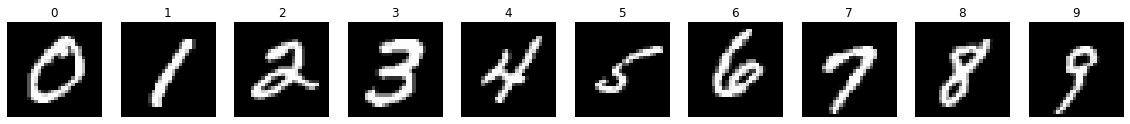

In [41]:
plt.figure(figsize=(20,20))

next_digit = 0
for i, matrix in enumerate(x_train):
  if y_train[i] == next_digit:
    digit = matrix.reshape(28, 28)
    plt.subplot(1, 10, next_digit+1)
    plt.imshow( digit/255 , cmap='gray') 
    plt.title(y_train[i])
    plt.axis('off') 
    if next_digit == 9:
      break
    else:
      next_digit += 1
plt.show()


### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 
Describe in text (preferably math notationns) the classification rule, and explain.

**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
**P(y=j | x)** = πⱼ * Pⱼ(x) / sum(Pⱼ(x)) = πⱼ * Pⱼ(x) ( sum(Pⱼ(x)) is constant ) \\
**j** - the label (number between 0 to 9) \\
**Priority** - \\
πⱼ = (number of times label j has appeared) / (number of all occurrences in the dataset) \\
**Likelihood** - \\
for Bernoulli with 0,1 pixel values: \\
Pⱼ(x) = mul(Pji(x)) = mul( pⱼᵢ^xᵢ * (1-pⱼᵢ)\^(1-xᵢ) ) \\
**Mul** mean we multiplicate all the xᵢ pixels  bernouli's probability \\
we will operate log on Pⱼ(x) so i will looks like: \\
Log(Pⱼ(x)) = sum(Log(Pji(x))) = sum( xᵢ * Log(pⱼᵢ) + (1-xᵢ) * Log(1-pⱼᵢ) ) \\

pⱼᵢ = (number of examples from class j with pixel xᵢ=1) / (number of examples from class j) \\

**Classification rule -** \
to find class Cᵢ we comput in the fit the probability for each pixel \\
belonging to each Cᵢ, and to predict the class that this example most likely associated with  we search (by argmax function), the class that maximizes this probality.

**Edge cases :** \\
1.  When we study the model there may be a pixel xᵢ that during learning was the same in all samples (0 or 1), but in the test the situation does not have to be this way. \\
To solve the problem we will use a **laplace** which gives a different probability from 0 even for cases that were not.

2. When others multiply a lot of probabilities there is a problem of converging to 0. \\
The solution to the problem is to use **logarithmic** form to sum up the probabilities.


#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2


In [42]:
bnb = BernoulliNB(binarize=0) # every pixel with value greater than 0 will be set to 1.
bnb.fit(x_train, y_train)

BernoulliNB(binarize=0)

mean images


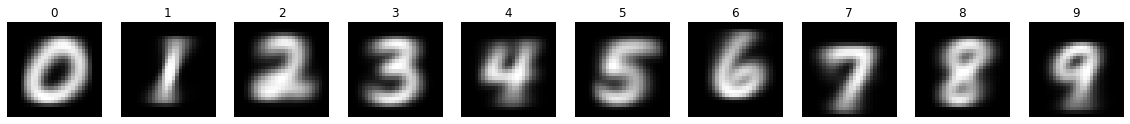

In [43]:
print("mean images")
plt.figure(figsize=(20,20))

for i in range(10):
  # e to the power of the likelihood will give us the probability of the pixel to be 1, thus basically getting the average shape of each number
  P_xy = np.exp(bnb.feature_log_prob_[i])
  plt.subplot(1,10, i+1)
  # reshape to (28,28) matrix
  plt.imshow(P_xy.reshape(28,28), cmap='gray')
  # the number above the mean image
  plt.title(i)
  plt.axis('off')

generate samples


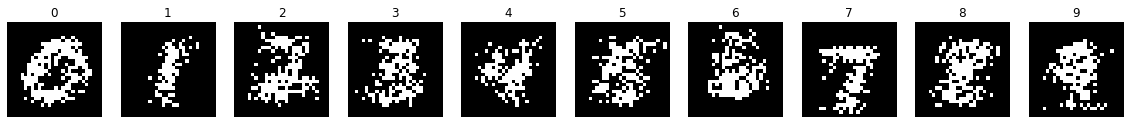

In [44]:
print('generate samples')
plt.figure(figsize=(20,20))

for i in range(10):
  # e to the power of the likelihood will give us the probability of the pixel to be 1, thus basically getting the average shape of each number
  gen_digit_prob = np.exp(bnb.feature_log_prob_[i])
  # Each likelihood of pixel will serve as a probability to be 1.
  array = map(lambda x: np.random.binomial(size=1,n=1,p=x)[0], gen_digit_prob)
  # reshape to (28,28) matrix
  image = np.fromiter(array,dtype=np.int).reshape((28,28))
  plt.subplot(1,10, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(i)
  plt.axis('off')

mean accuracy on test data:  0.8413
mean accuracy on train data:  0.83125


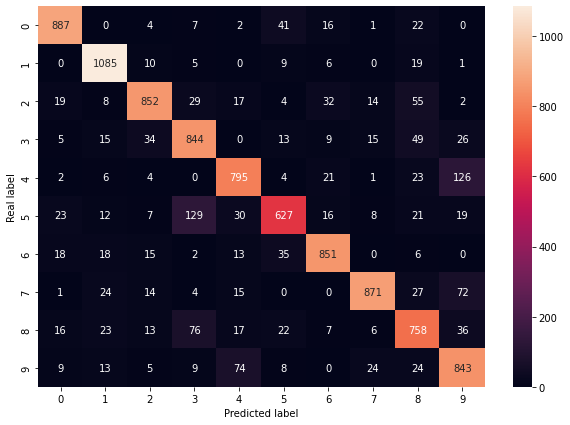

In [45]:
y_test_pred = bnb.predict(x_test)
plt.figure(figsize=(10,7))
confusion_m = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confusion_m, annot=True, fmt="d")
plt.ylabel('Real label')
plt.xlabel('Predicted label')

# Calculate the total accuracy
print('mean accuracy on test data: ' , bnb.score(x_test,y_test))
print('mean accuracy on train data: ' , bnb.score(x_train,y_train))

**--2--** \\
**a.** The accuracy of the model on the test set is 84.4%, which means that the generative model works well. \\
**b.** It can be seen that the accuracy between the test set and the train is almost the same, meaning that the model is not in an over-fitting state. \\
**c.** The largest number of errors was when the model predicted the number 5 as 3 and when the model predicted the number 4 as 9, and indeed it can be seen that their shapes are relatively similar, But even so, when the model predicted 3 as 5 and 9 as 4 he was less wrong.

**--3--** \\
We can iteratively go through the numbers from 0 to 255 and check which of these numbers will serve as the treshold of the binarize parameter. we will choose the number that will give the model with the highest scores on the test_set.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

### You task
Implement the barebone class provided: `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.

Then follow next anlysis guidlinnes using the implemented class for train and test classifier:
* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).


**Load the train data using from sklearn.datasets import fetch_20newsgroups. remove headers, footers and quotes (see documentation)**

In [46]:
train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='train')
test = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='test')

In [63]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
  def fit(self, x, y):
    x = x.toarray()
    # number of features
    self.n_features = x.shape[1]
    # number of labels
    self.n_labels = len(set(y))
    self.log_prior = {}
    self.log_likelihood = {}
    for label in range(self.n_labels):
      x_label = x[label == y] ## save all vectors in train set with the same labels
      self.log_prior[str(label)] = np.log(x_label.shape[0] / x.shape[0]) ## priority of each label
      self.log_likelihood[str(label)] = np.log((x_label.sum(0) + 1) / (x_label.sum(0).sum() + self.n_features)) ## Add 1 for smoothing

  def predict_log_proba(self, x):
    x =x.toarray()
    # (20,n_features) matrix of zero's
    probs = np.zeros((x.shape[0],self.n_labels))
  
    for document in range(x.shape[0]):
      for label in range(self.n_labels):
        # log on X array
        array_prob = self.log_likelihood[str(label)]
        # sum the priority of the label with the word likelihoods
        probs[document][label] = self.log_prior[str(label)] + (x[document] * array_prob.T).sum()
    return probs

  def predict(self, x): # return the label that naximize the probability for each text
    return np.argmax(self.predict_log_proba(x), axis=1)

In [64]:
#compare the accuracy over the test data. You can use accuracy_score, classification_report
model = make_pipeline(CountVectorizer(stop_words='english',max_features=10000), NaiveBayes())
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [65]:
score = metrics.accuracy_score(test.target, labels)
print("accuracy of our model is :   %0.3f" % score)
print("classification report our NB :")
class_report = metrics.classification_report(test.target, labels,
                                            target_names=test.target_names)
print(class_report)

accuracy of our model is :   0.628
classification report our NB :
                          precision    recall  f1-score   support

             alt.atheism       0.44      0.50      0.47       319
           comp.graphics       0.51      0.71      0.60       389
 comp.os.ms-windows.misc       0.33      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.47      0.67      0.55       392
   comp.sys.mac.hardware       0.57      0.65      0.61       385
          comp.windows.x       0.71      0.69      0.70       395
            misc.forsale       0.80      0.73      0.76       390
               rec.autos       0.68      0.72      0.70       396
         rec.motorcycles       0.71      0.74      0.73       398
      rec.sport.baseball       0.81      0.79      0.80       397
        rec.sport.hockey       0.55      0.79      0.65       399
               sci.crypt       0.76      0.68      0.72       396
         sci.electronics       0.61      0.51      0.55       393
         

In [50]:
model = make_pipeline(CountVectorizer(stop_words='english',max_features=10000), MultinomialNB())
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [51]:
score = metrics.accuracy_score(test.target, labels)
print("accuracy of our model is :   %0.3f" % score)
print("classification report our NB :")
classification_report = metrics.classification_report(test.target, labels,
                                            target_names=test.target_names)
print(classification_report)

accuracy of our model is :   0.628
classification report our NB :
                          precision    recall  f1-score   support

             alt.atheism       0.44      0.50      0.47       319
           comp.graphics       0.51      0.71      0.60       389
 comp.os.ms-windows.misc       0.33      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.47      0.67      0.55       392
   comp.sys.mac.hardware       0.57      0.65      0.61       385
          comp.windows.x       0.71      0.69      0.70       395
            misc.forsale       0.80      0.73      0.76       390
               rec.autos       0.68      0.72      0.70       396
         rec.motorcycles       0.71      0.74      0.73       398
      rec.sport.baseball       0.81      0.79      0.80       397
        rec.sport.hockey       0.55      0.79      0.65       399
               sci.crypt       0.76      0.68      0.72       396
         sci.electronics       0.61      0.51      0.55       393
         

**Our NB VS sklearn's model Discutions:**\
We can see that the accuracy of the two models for 10000 features is the same(0.628), which means that we were able to realize well the idea of naive bayes while making a smooth for the probabilities of the words in each class.

**compare to TfidfVectorizer preprocessing (you can use the built in model for doing the analysis)**

In [52]:
model = make_pipeline(TfidfVectorizer(stop_words='english',max_features=10000), NaiveBayes())
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [53]:
score = metrics.accuracy_score(test.target, labels)
print("accuracy of our model is :   %0.3f" % score)
print("classification report our NB :")
classification_report = metrics.classification_report(test.target, labels,
                                            target_names=test.target_names)
print(classification_report)

accuracy of our model is :   0.675
classification report our NB :
                          precision    recall  f1-score   support

             alt.atheism       0.61      0.26      0.37       319
           comp.graphics       0.61      0.68      0.65       389
 comp.os.ms-windows.misc       0.64      0.61      0.63       394
comp.sys.ibm.pc.hardware       0.60      0.69      0.64       392
   comp.sys.mac.hardware       0.74      0.65      0.70       385
          comp.windows.x       0.79      0.76      0.78       395
            misc.forsale       0.76      0.79      0.77       390
               rec.autos       0.75      0.70      0.73       396
         rec.motorcycles       0.79      0.74      0.77       398
      rec.sport.baseball       0.88      0.79      0.84       397
        rec.sport.hockey       0.56      0.92      0.70       399
               sci.crypt       0.74      0.75      0.74       396
         sci.electronics       0.67      0.50      0.57       393
         

**TfidfVectorizer VS CountVectorizer Discutions:** \\
from the accuracy measure, we can see that the TfidfVectorizer performs a bit better, (0.675 vs 0.628). the difference between the two that the TfidfVectorizer returns scores and the CountVectorizer returns counts. \\
we can learn from this test that in this case, the more complicated model wins. 

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

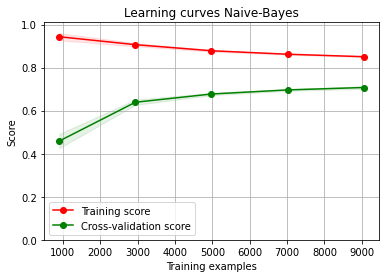

In [55]:
title = r"Learning curves Naive-Bayes"
dataset = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
cv = ShuffleSplit(n_splits = 5, test_size=0.2, random_state=2)
plot_learning_curve(make_pipeline(TfidfVectorizer(stop_words='english', max_features=10000), NaiveBayes()), title, dataset.data, dataset.target, ylim=(0, 1.01), cv=cv)

plt.show()

**Explain** - \\
In the beginning when the training set is small the bias is low because the success rate in the training set is high and as the number of samples in the training set increases the bias increases because the success rate on the training set becomes smaller.\
On the other hand the variance is high at first because the success rates on the testing set are low but as the number of samples increases the success rates on the testing set increase so the variance is small.



### Bonus I (5 points)
#### Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words.

In [56]:
import string
def print_txt(txt, hot, cold):
  """
  print the text, coloring hot and cold words with colors
  """
  cold_color='\x1b[41;37m{}\x1b[0m'
  hot_color='\x1b[42;37m{}\x1b[0m'
  def color(token):
    lower = str(token).lower()
    lower = lower.replace('\t','').replace('\n','')
    lower = lower.translate(string.punctuation)
    if (lower in hot) and (lower in cold):
      return mid_color.format(token)
    elif lower in hot:
      return hot_color.format(token)
    elif lower in cold:
      return cold_color.format(token)
    else:
      return token
  colored_txt = " ".join([color(token) for token in txt.split(' ')])
  print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other


In [57]:
def calc_p_c_given_xi(model):
  pcxi = np.zeros((20, model.feature_log_prob_.shape[1]))

  pXi = model.feature_count_.sum(0) / model.feature_count_.sum()

  pc = np.exp(1)**model.class_log_prior_
  
  pxCi = np.exp(1)**model.feature_log_prob_

  pcxi = (pc * pxCi.T) / pXi.reshape((pXi.shape[0],1))

  return pcxi.T

In [58]:
def good_bad_Words(sentence, pipeline, pcxi, p_class, badClass):
  counter = CountVectorizer(stop_words = "english")
  existWords = {}
  correct = []
  wrong = []
  vec = pipeline["countvectorizer"]

  X = counter.fit_transform([sentence])
  words = counter.get_feature_names_out()
  for word in words:
    try:
      existWords[word] = vec.vocabulary_[word]
    except KeyError:
      continue
  
  for word, index in existWords.items():
    argMax = np.argmax(pcxi[:, index])
    if argMax == p_class:
      correct.append(word)
    elif argMax == badClass:
      wrong.append(word)
  
  return correct, wrong

In [59]:
# Model
model = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())
model.fit(train.data, train.target)
# pcxi matrix
pcxi = calc_p_c_given_xi(model['multinomialnb'])
# wrong class of row 7
badClass = model.predict(test.data)[7]
# right class of row 7
pClass = test.target[7]
# sentence of row 7
Sentence = test.data[7]
#this function gives us the correct and wrong words of each sentence
correct, wrong = good_bad_Words(Sentence, model, pcxi, pClass, badClass)
# use print text
print_txt(Sentence, correct, wrong)


A friend of mine managed to get a copy of a computerised Greek and Hebrew 
Lexicon called "The Word Perfect" (That is not the word processing 
package WordPerfect). However, some one wiped out the EXE file, and she 
has not been able to restore it. There are no distributors of the package in 
South Africa. I would appreciate it, if some one could email me the file, or 
at least tell me where I could get it from. 

My email address is
	fortmann@superbowl.und.ac.za     or
	fortmann@shrike.und.ac.za
 
Many thanks.


### Bonus II (5 points)
#### How can you correct the analyzed error?

To read more about model interpretation, see the blogpost below and the tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

Answer for 2nd bonus

1. **Word Frequency Information -** \\
In a text if a particular word appears once it is more likely to appear again, whereas in the Naive Base model we assume the number of occurrences of a word in the text, and multiply its number of occurrences by its probability given a particular class, so to avoid this you can smooth over a number The occurrences of a word. \\
Xₜ' = log(Xₜ + 1) **or** Xₜ = min{1,Xₜ} - for smooth the frequency

2. **Prior probabilities -** \\
In texts where the number of words is not large the priority of each class has a greater effect, so instead of training the priority of each class according to the training set, it is possible to give the same probability to each class in a uniform way.

3. **Feature selection(CRQ)** - \\
To improve the way words are selected as features, the CRQ-cluster representation quality scoring method can be used.
The purpose of this scoring method is that unlike the option of choosing the words that will serve us as features only by their probability, in this method we look for word groups that belong to the same cluster and minimize the distance between them, and on the other hand maximize the distance between words in different clusters.
Basically with the help of this method we will extract words from the dictionary whose publication will improve the quality of the cluster.